## Physics-Informed Neural Networks (PINNs) Practical Exercise
## Solving the 1D Heat Equation using PINNs

### imports and installations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set seed for reproducibility
torch.manual_seed(42)

## Configure 1D heat equation system parameters 

#### System Parameters 

In [2]:
alpha = 0.001       # original thermal diffusivity [m^2/s]
L     = 1       # domain length [m]
T_max = 1     # max time [s]
U_max = 1    # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

### Set up initial conditions configuration
##### Consider 2 optional IC setups- sinusoidal and block heat source


In [71]:
# create a sinusoidal distribution initial condition
def i_c_sin(x_initial):
    u_initial = torch.sin(torch.pi * x_initial) 
    return u_initial

# create a block heat source initial condition (temperature distribution between 0 and 1)
def i_c_block(x_initial):
    center1 = 0.35
    center2 = 0.8
    width1 = 0.2
    width2 = 0.35
    # Create mask for points inside the block
    mask1 = (x_initial >= (center1 - width1/2)) & (x_initial <= (center1 + width1/2))
    mask2 = (x_initial >= (center2 - width2/2)) & (x_initial <= (center2 + width2/2))
    # Initialize with low temperature
    u_initial = torch.full_like(x_initial, 0)
    # Set high temperature for points inside the block
    u_initial[mask1] = 1
    u_initial[mask2] = 1
    
    return u_initial

# generate initial conditions training data
def generate_initial_data(num_boundary_points, system_params, initial_condition = i_c_sin):
    x_initial = torch.rand(num_boundary_points, 1, requires_grad=True) # random x values (0-1) for the initial condition
    t_initial = torch.zeros_like(x_initial) # time is 0 for the initial condition
    u_initial = initial_condition(x_initial) # create the initial temperature distribution
    # scale the initial data to the system parameters
    x_initial = x_initial * system_params['L']
    u_initial = u_initial * system_params['U_max']
    return x_initial, t_initial, u_initial


### Configure Boundry Conditions & Domain Training points

In [65]:
def generate_boundary_data(num_boundary_points, system_params, boundary_value=0):
    # create x_boundary and t_boundary
    x_boundary_0 = torch.zeros(num_boundary_points, 1, requires_grad=True)  # x = 0 boundary
    x_boundary_1 = torch.ones(num_boundary_points, 1, requires_grad=True) * system_params['L'] # x = L boundary
    x_boundary = torch.cat([x_boundary_0, x_boundary_1], dim=0)   # combine both boundaries

    t_boundary = torch.rand(num_boundary_points * 2, 1, requires_grad=True) * system_params['T_max']  # random time points to match the boudaries

    u_boundary = torch.full_like(x_boundary, boundary_value) # set the boundary values to the boundary points

    return x_boundary, t_boundary, u_boundary

# Generate a random setup of interior domain points to train the model on
def generate_domain_points(num_domain_points, system_params):
    x_domain = torch.rand(num_domain_points, 1, requires_grad = True) * system_params['L']
    t_domain = torch.rand(num_domain_points, 1, requires_grad = True) * system_params['T_max']
    
    return x_domain,t_domain

### Plot IC and BC

In [69]:
def plot_IC_BC(num_domain_points=num_domain_points,
                num_boundary_points=num_boundary_points,
                system_params=system_params,
                initial_condition=i_c_sin, plot_IC_alone=True):
    # Generate data
    x_domain, t_domain= generate_domain_points(num_domain_points, system_params)
    x_boundary, t_boundary, u_boundary = generate_boundary_data(num_boundary_points, system_params, boundary_value=0)
    x_initial, t_initial, u_initial = generate_initial_data(num_boundary_points, system_params, initial_condition)
    # Convert to numpy arrays
    x_init_np , t_init_np , u_init_np = x_initial.detach().numpy(), t_initial.detach().numpy(), u_initial.detach().numpy()
    x_boundary_np , t_boundary_np , u_boundary_np = x_boundary.detach().numpy(), t_boundary.detach().numpy(), u_boundary.detach().numpy()
    # Unite all x,t,u in one array
    x_np = np.concatenate((x_init_np, x_boundary_np))
    t_np = np.concatenate((t_init_np, t_boundary_np))
    u_np = np.concatenate((u_init_np, u_boundary_np))

    if plot_IC_alone:
        fig = plt.figure(figsize=(8, 4))
        # Scatter plot of u_init_np vs x_init_np
        plt.scatter(x_init_np, u_init_np, c=u_init_np, cmap='coolwarm')
        plt.xlabel('Position x (m)')
        plt.ylabel('Temperature u (°C)')
        plt.title('Initial Condition at time t=0')
        plt.colorbar(label='Temperature')
        plt.show()


    # For a 2D tilted view (alternative approach)
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Create a surface plot with zero height
    x_grid, t_grid = np.meshgrid(np.unique(x_np), np.unique(t_np))
    z_grid = np.zeros_like(x_grid)  # Create a flat surface
    ax.plot_surface(x_grid, t_grid, z_grid, alpha=0.15) # Plot the surface

    # Add scatter points
    scatter = ax.scatter(x_np, t_np, np.zeros_like(x_np), c=u_np, cmap='coolwarm')
    # Set figure view
    ax.set_xlabel('Position x (m)')
    ax.set_ylabel('Time t (s)')
    ax.set_zticks([]) # Remove z-axis
    ax.view_init(elev=20, azim=-45) # Adjust view angle for 2D-like perspective

    plt.colorbar(scatter, label='Temperature')
    plt.title('Initial Condition and Boundary Condition')
    plt.show()


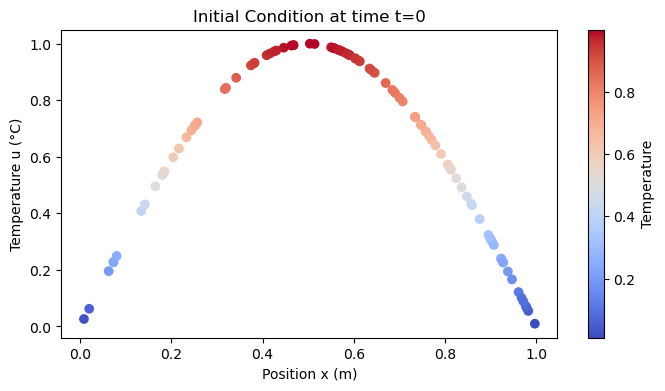

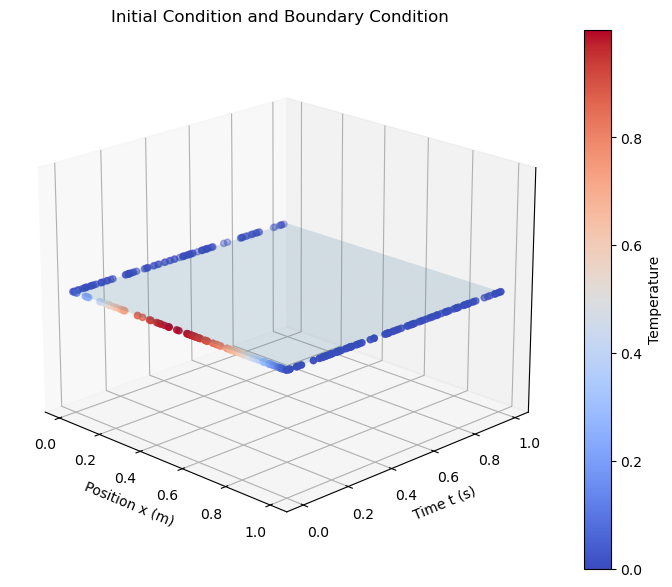

In [72]:
plot_IC_BC(num_domain_points, num_boundary_points, initial_condition=i_c_sin)

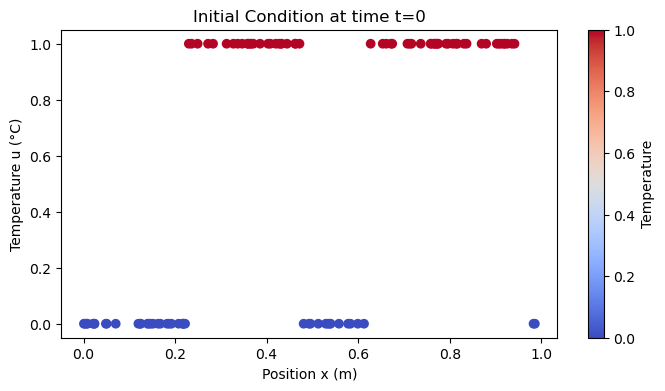

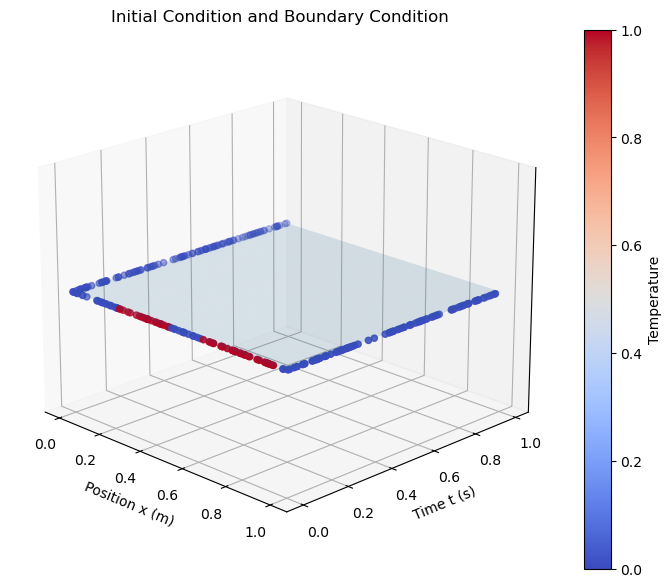

In [68]:
plot_IC_BC(num_domain_points, num_boundary_points, initial_condition=i_c_block)

## Define PINN Architecture

In [36]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.net(x)

In [37]:
def pde(x,t,model,system_params):
    input_data = torch.cat([x,t],dim=1)
    u = model(input_data)
    alpha= system_params['alpha']

    u_x = torch.autograd.grad(u, x,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x,x,grad_outputs= torch.ones_like(u_x), create_graph= True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u,t,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    heat_eq_residual = alpha * u_xx - u_t
    return heat_eq_residual

In [78]:
def train_PINN(model, num_iterations, system_params, num_domain_points, num_boundary_points, initial_condition=i_c_sin,
               loss_weights = {'ic': 1, 'bc': 1, 'pde': 1}, print_loss = True):
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ic_losses = []
    bc_losses = []
    pde_losses = []
    total_losses = []
    w_ic = loss_weights['ic']
    w_bc = loss_weights['bc']
    w_pde = loss_weights['pde']
    
    for  iteration in range(num_iterations):
        optimizer.zero_grad()

        x_domain, t_domain= generate_domain_points(num_domain_points, system_params)
        
        x_boundary, t_boundary, u_boundary = generate_boundary_data(num_boundary_points, system_params, boundary_value=0)
        
        x_initial, t_initial, u_initial = generate_initial_data(num_boundary_points, system_params, initial_condition)
        
        residual = pde(x_domain,t_domain,model,system_params)
        
        ic_loss= nn.MSELoss()(u_initial, model(torch.cat([x_initial, t_initial], dim=1))) * w_ic
        bc_loss = nn.MSELoss()(u_boundary, model(torch.cat([x_boundary, t_boundary], dim=1))) * w_bc
        pde_loss = nn.MSELoss()(residual, torch.zeros_like(residual)) * w_pde
        loss = ic_loss + bc_loss + pde_loss
        loss.backward()
        optimizer.step()

        # Accumulate losses
        ic_losses.append(ic_loss.item())
        bc_losses.append(bc_loss.item())
        pde_losses.append(pde_loss.item())
        total_losses.append(loss.item())

    
        # Print loss every 100 iterations and check for early stopping
        if iteration % 1000 ==0:
            if print_loss:
                print("iter", iteration, "total_loss", f"{loss.item():.3f}", "ic_loss", f"{ic_loss.item():.4f}", "bc_loss", f"{bc_loss.item():.4f}", "pde_loss", f"{pde_loss.item():.4f}")

    # insert all losses to a dataframe
    df = pd.DataFrame({'ic_loss': ic_losses, 'bc_loss': bc_losses, 'pde_loss': pde_losses, 'total_loss': total_losses})
    return df


## Train model & Evaluate results

In [74]:
def plot_PINN_results(model, system_params, num_time_steps=10):
    x_plot = []
    t_plot = []
    u_pred = []
    with torch.no_grad():
        x_vals = torch.linspace(0,system_params['L'],100)
        for t in range(num_time_steps):
            t_val = torch.ones_like(x_vals) * t/num_time_steps * system_params['T_max']
            input_data = torch.stack([x_vals.flatten(),t_val.flatten()], dim=1)
            solution = model(input_data)
            x_plot.append(x_vals)
            t_plot.append(t_val)
            u_pred.append(solution)

    # Convert to numpy and flatten all arrays
    x_plot = torch.cat(x_plot).numpy()
    t_plot = torch.cat(t_plot).numpy()
    u_pred_np = torch.cat(u_pred).numpy()

    # Plot
    plt.figure(figsize=(8, 7))
    plt.scatter(x_plot, t_plot, c=u_pred_np, cmap='coolwarm')
    plt.clim(0, system_params['U_max'])
    plt.ylim(0, system_params['T_max'])
    plt.xlabel('Position x (m)')
    plt.ylabel('Time t (s)')
    plt.title('PINN Temperature Prediction')
    plt.colorbar(label='Temperature')
    plt.show()

def plot_losses(df):
    plt.figure(figsize=(9, 4))
    plt.plot(df['total_loss'], label='Total Loss')
    plt.plot(df['ic_loss'], label='IC Loss')
    plt.plot(df['bc_loss'], label='BC Loss')
    plt.plot(df['pde_loss'], label='PDE Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Losses over iterations')
    plt.legend()
    plt.show()

### Block IC , Norm Values
- Try playing with alpha values

iter 0 total_loss 0.572 ic_loss 0.5313 bc_loss 0.0327 pde_loss 0.0085
iter 1000 total_loss 0.187 ic_loss 0.1763 bc_loss 0.0062 pde_loss 0.0050
iter 2000 total_loss 0.130 ic_loss 0.1128 bc_loss 0.0054 pde_loss 0.0120
iter 3000 total_loss 0.077 ic_loss 0.0634 bc_loss 0.0043 pde_loss 0.0097
iter 4000 total_loss 0.051 ic_loss 0.0402 bc_loss 0.0034 pde_loss 0.0070
iter 5000 total_loss 0.057 ic_loss 0.0508 bc_loss 0.0018 pde_loss 0.0042
iter 6000 total_loss 0.054 ic_loss 0.0484 bc_loss 0.0015 pde_loss 0.0036
iter 7000 total_loss 0.047 ic_loss 0.0422 bc_loss 0.0011 pde_loss 0.0033
iter 8000 total_loss 0.045 ic_loss 0.0399 bc_loss 0.0019 pde_loss 0.0027
iter 9000 total_loss 0.038 ic_loss 0.0345 bc_loss 0.0012 pde_loss 0.0027


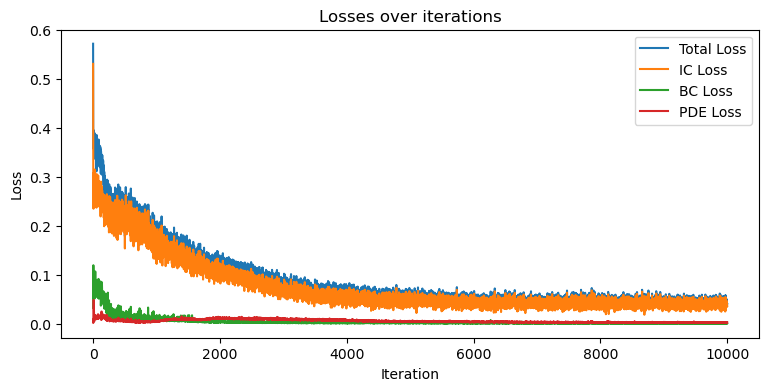

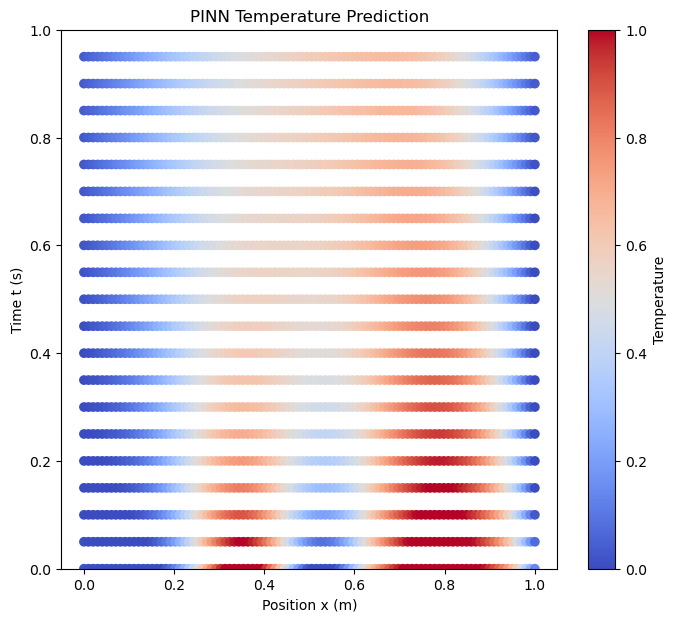

In [85]:
alpha = 0.02       # original thermal diffusivity [m^2/s]
L     = 1       # domain length [m]
T_max = 1   # max time [s]
U_max = 1   # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model = PINN()
losses = train_PINN(model,
                    num_iterations = 10000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_block,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 1},
                    )

plot_losses(losses)
plot_PINN_results(model,system_params, num_time_steps=20)


### Sinus IC , Norm Values
- Try swithcing on/off the loss weights

iter 0 total_loss 0.742 ic_loss 0.7179 bc_loss 0.0231 pde_loss 0.0012
iter 1000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0002
iter 2000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0001
iter 3000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0000
iter 4000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0000


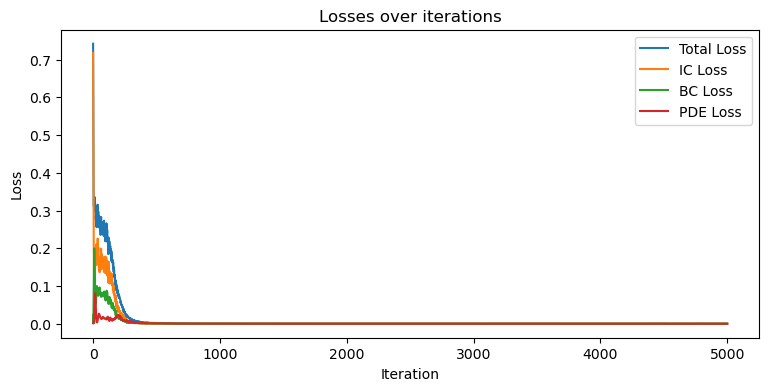

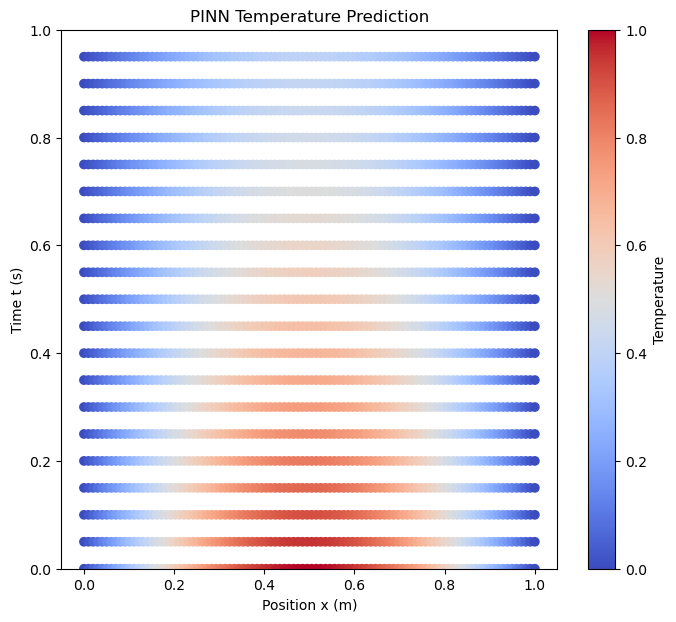

In [97]:
alpha = 0.1 # thermal diffusivity [m^2/s]
L     = 1   # domain length [m]
T_max = 1   # max time [s]
U_max = 1   # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model = PINN()
losses = train_PINN(model,
                    num_iterations = 5000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_sin,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 1},
                    )

plot_losses(losses)
plot_PINN_results(model,system_params, num_time_steps=20)

### Sinus IC , "Real" Values
- Try swithcing balancing the loss weights

### Need to creat an alpha norm param to fix this ###

iter 0 total_loss 5288.555 ic_loss 5288.0220 bc_loss 0.0308 pde_loss 0.5026
iter 1000 total_loss 911.167 ic_loss 856.6831 bc_loss 23.0665 pde_loss 31.4174
iter 2000 total_loss 82.545 ic_loss 75.5098 bc_loss 2.0527 pde_loss 4.9821
iter 3000 total_loss 9.393 ic_loss 7.7387 bc_loss 0.2915 pde_loss 1.3631
iter 4000 total_loss 1.311 ic_loss 0.8504 bc_loss 0.1016 pde_loss 0.3585
iter 5000 total_loss 1.109 ic_loss 0.2912 bc_loss 0.6492 pde_loss 0.1681
iter 6000 total_loss 0.459 ic_loss 0.1083 bc_loss 0.1677 pde_loss 0.1829
iter 7000 total_loss 0.106 ic_loss 0.0225 bc_loss 0.0086 pde_loss 0.0744
iter 8000 total_loss 0.054 ic_loss 0.0073 bc_loss 0.0035 pde_loss 0.0430
iter 9000 total_loss 0.260 ic_loss 0.0692 bc_loss 0.1465 pde_loss 0.0448


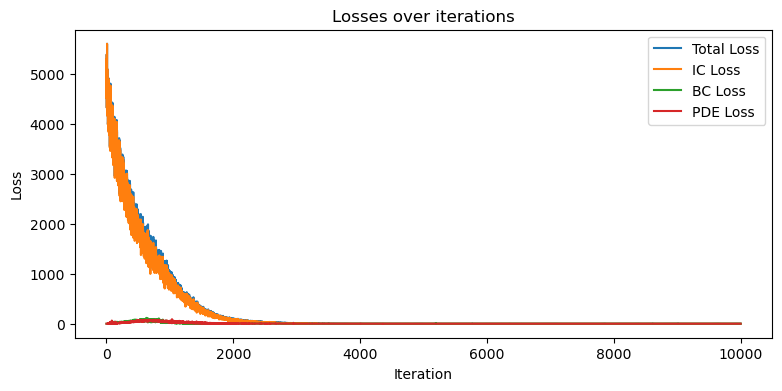

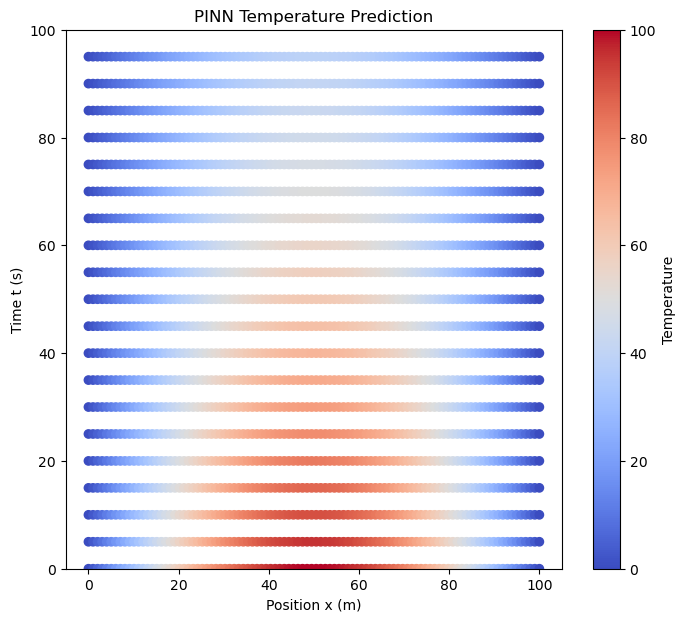

In [104]:
alpha = 10       # original thermal diffusivity [m^2/s]
L     = 100       # domain length [m]
T_max = 100   # max time [s]
U_max = 100  # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model = PINN()
losses = train_PINN(model,
                    num_iterations = 10000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_sin,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 100},
                    )

plot_losses(losses)
plot_PINN_results(model,system_params, num_time_steps=20)